In the previous lecture, we built a simple `bigram` character-level language model, using 2 different approaches that are (1) count, and (2) 1 layer neural network. They produced the same (and both poor - since the context is 1 character only) result but the neural network option offers more flexibility so that we can complexify our model to get better performance.

In this lecture we are going to implement 20-years ago neural probabilistic language model by *Bengio et al. (2003)*.

# PART 1: intro to MLP

## Bengio et al. 2003 (MLP language model) paper walkthrough

### Summary

**Problem Statement**:

-   Traditional n-gram language models suffer from the *curse of dimensionality*: they can't effectively generalize to word sequences not seen in training data;
-   The core issue is treating words as atomic units with no *inherent similarity* to each other;
-   For example, if we've seen "dog is eating" in training but never "cat is eating", n-gram models can't leverage the similarity between "dog" and "cat";
-   This leads to poor probability estimates for rare or unseen word sequences.

**Solution**:

-   Learn a *distributed representation* (embedding) for each word in a continuous vector space where similar words are close to each other;
-   Use a neural network architecture with:
    -   Input layer: concatenated embeddings of n-1 previous words;
    -   Hidden layer: dense neural network with `tanh` activation;
    -   Output layer: softmax over entire vocabulary to predict next word probability.

**The model simultaneously learns**:

-   Word feature vectors (embeddings) that capture *semantic/syntactic word similarities*;
-   Neural network parameters that combine these features to estimate probability distributions.

**Key advantages**:

-   Words with similar meanings get similar feature vectors, enabling better *generalization*;
-   The probability function is smooth with respect to word embeddings, so similar words yield *similar predictions*;
-   Can generalize to *unseen sequences* by leveraging learned word similarities.

### Methodology:

-   Traditional Problem:

    -   In n-gram models, each word sequence of length n is a separate parameter;
    -   For vocabulary size $|V|$, need $|V|^n$ parameters;
    -   Most sequences never appear in training, leading to poor generalization;

-   Solution via **Distributed Representation**:

    -   Each word mapped to a dense vector in $R^m$ (typically m=50-100);
    -   Similar words get similar vectors through training;
    -   Probability function is smooth w.r.t these vectors;
    -   Key benefit: If "dog" and "cat" have similar vectors, model can generalize from "dog is eating" to "cat is eating";
    -   Number of parameters reduces to $O(|V|×m + m×h + h×|V|)$, where $h$ is hidden layer size;
    -   This is much smaller than $|V|^n$ and allows better generalization;

### Neural architecture:

**Input Layer**:

-   Takes $n-1$ previous words (context window);
-   Each word i mapped to vector $C(i) ∈ R^m$ via lookup table;
-   Concatenates these vectors: $x = [C(wₜ₋ₙ₊₁), ..., C(wₜ₋₁)]$;
-   $x$ dimension is $(n-1)×m$;

**Hidden Layer**:

-   Dense layer with tanh activation;
-   Computation: $h = tanh(d + Hx)$;
-   $H$ is weight matrix, $d$ is bias vector;
-   Maps concatenated context to hidden representation;

**Output Layer**:

-   Computes probability distribution over all words;
-   $y = b + Wx + Uh$;
-   Softmax activation: $P(wₜ|context) = exp(yᵢ)/Σⱼexp(yⱼ)$;
-   $W$ provides "shortcut" connections from input to output;
-   Direct connection helps learn simpler patterns;

**Training**:

-   Maximizes log-likelihood of training data;
-   Uses stochastic gradient descent;
-   Learns both word vectors $C(i)$ and neural network parameters $(H, d, W, U, b)$;
-   Word vectors capture similarities as they help predict similar contexts;
-   Can initialize word vectors randomly or with pretrained vectors.

![Neural Language Model proposed by (Bengio et al., 2003). C(i) is the i th word embedding.](NLM_Bengio_etal.png)

## (re-)building our training dataset

Loading library, reading data, building dictionary:

In [ ]:
import torch
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
url = "https://raw.githubusercontent.com/karpathy/makemore/refs/heads/master/names.txt"
words = pd.read_csv(url, header=None).iloc[:, 0].tolist()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mapping to/from integer
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.'] = 0

itos = {i: s for s, i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

Building the dataset:

In [6]:
block_size = 3 # the context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words[:5]:
    print(w)
    context = [0] * block_size # 0 so context will be padded by '.'
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '----->', itos[ix] )
        context = context[1:] + [ix] # rolling to the next one

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... -----> e
..e -----> m
.em -----> m
emm -----> a
mma -----> .
olivia
... -----> o
..o -----> l
.ol -----> i
oli -----> v
liv -----> i
ivi -----> a
via -----> .
ava
... -----> a
..a -----> v
.av -----> a
ava -----> .
isabella
... -----> i
..i -----> s
.is -----> a
isa -----> b
sab -----> e
abe -----> l
bel -----> l
ell -----> a
lla -----> .
sophia
... -----> s
..s -----> o
.so -----> p
sop -----> h
oph -----> i
phi -----> a
hia -----> .


In [7]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([32, 3]), torch.int64, torch.Size([32]), torch.int64)

## implementing the embedding lookup table

In the paper they cram 17k word into as-low-as-possible 30 dimensions space, for our data, we just cram words into 2D space.

In [8]:
C = torch.randn((27, 2))

We can access the element of `torch.tensor` by:

In [9]:
C[5] # can be integer, list [5, 6, 7], or torch.tensor([5,6,7])
# > tensor([1.0825, 0.2010])

# or

F.one_hot(torch.tensor(5), num_classes=27).float() @ C
# produce identical result, remember torch.tensor() infer long dtype int64, so we need to cast to float

tensor([-0.6608,  0.2861])

...but in this lecture accessing by `C[5]` would be sufficient. We can even access using a more than 1 dimension tensor:

In [10]:
print(C[X].shape)
print(X[13, 2]) # integer 1 for 13rd index of 2nd dimension
print(C[X][13,2]) # will be the embedding of that element
print(C[1]) # so C[X][13,2] = C[1]

torch.Size([32, 3, 2])
tensor(1)
tensor([-0.7415,  1.0744])
tensor([-0.7415,  1.0744])


PyTorch is great for embedding words:

In [11]:
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

We've compeleted the first layer with `context` and lookup table!

## implementing the hidden layer + internals of `torch.Tensor`: `storage`, `views`

In [12]:
# input of tanh layer will be 6 (3 words in context x 2 dimensions)
# and the number or neurons is up to us - let's set it 100
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

Now we need to do something like `emb @ W1 + b1`, but `emb.shape` is `[32, 3, 2]` and `W1.shape` is `[6, 100]`. We need to somehow concatnate/transform:

In [13]:
# emb[:, 0, :] is tensor for each input in the 3-words context, shape is [32, 2]
# cat 3 of them using the 2nd dimension (index 1) -> so we set dim = 1
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape

torch.Size([32, 6])

However this code does not change dynamically when we change the block size. We will be using `torch.unbind()`

In [14]:
# this is good!
torch.cat(torch.unbind(emb, 1), 1).shape
# new memory for storage is created, so it is not efficient

torch.Size([32, 6])

This works, but we have a better and more efficient way to do this. Since:

-   every `torch.Tensor` have `.storage()` which is one-dimensional vector tensor;
-   when we call `.view()`, we instruct how this vector tensor is interpreted;
-   no memory is being changed/copied/moved/or created. the storage is identical.

Readmore: <http://blog.ezyang.com/2019/05/pytorch-internals/>

So this hidden layer can be declared:

In [15]:
# instead or 32 we can write emb.shape[1], or -1 (whatever fitted)
h = emb.view(-1, 6) @ W1 + b1
h.shape

torch.Size([32, 100])

Notice that in the final operation, `b1` will be broadcasted.

## implementing the output layer

In [16]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In Deep Learning, people use `logits` for what raw output that range from negative inf to positive inf.

In [17]:
logits = h @ W2 + b2

In [18]:
logits.shape

torch.Size([32, 27])

Now we need to exponentiate it and get the probability.

In [19]:
counts = logits.exp()

In [20]:
probs = counts / counts.sum(1, keepdims=True)

In [21]:
probs.shape

torch.Size([32, 27])

Every row of `probs` has sum of 1.

In [22]:
probs[0].sum()

tensor(1.)

And this is the `probs` of each ground true `Y` in current output of the neural nets:

In [23]:
probs[torch.arange(32), Y]

tensor([7.7495e-24, 2.1101e-40, 1.9229e-21, 1.4055e-38, 7.7326e-28, 1.3492e-08,
        6.8267e-17, 1.4246e-24, 0.0000e+00, 1.4824e-30, 5.9416e-25, 2.6303e-27,
        9.4385e-09, 1.0000e+00, 1.3632e-21, 2.2708e-16, 5.6390e-31, 2.6454e-24,
        8.0710e-16, 4.0562e-25, 4.6443e-09, 5.1121e-03, 1.4884e-25, 7.8136e-33,
        3.4907e-21, 1.6266e-19, 3.1967e-12, 4.7231e-16, 3.9659e-06, 5.4454e-22,
        3.4041e-04, 2.8871e-16])

Result is not good as we've not trained the network yet!

## implementing the negative log likelihood loss

We define the negative log likelihood as:

In [24]:
loss = - probs[torch.arange(32), Y].log().mean()
loss

tensor(inf)

## summary of the full network

Dataset:

In [25]:
X.shape, Y.shape

(torch.Size([32, 3]), torch.Size([32]))

Neural network layers:

In [26]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

parameters = [C, W1, b1, W2, b2]

Size of the network:

In [27]:
sum(p.nelement() for p in parameters)

3481

Constructing forward pass:

In [28]:
emb = C[X] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
counts = logits.exp()
probs = counts / counts.sum(1, keepdims=True)
loss = - probs[torch.arange(32), Y].log().mean()
loss

tensor(17.7697)

# PART 2: intro to many basics of machine learning

## introducing `F.cross_entropy` and why

We re-define loss:

In [29]:
loss = F.cross_entropy(logits, Y)
loss

tensor(17.7697)

Why?

-   Pytorch will create more intermediate tensor for every assignment: `counts`, `probs` -\> more memory;
-   Backward pass will be more optimized, because the expressions are much analytically and mathematically interpreted;
-   Cross entropy can be significantly & numerically well behaved (for eg when we exponentiate a large positive number we got inf, PyTorch cross entropy will calculate the max of set and subtract it - which will not impact the exp result)

## implementing the training loop, overfitting one batch

So the forward pass, backward pass, and update loop will be implemented as below:

In [30]:
for p in parameters:
    p.requires_grad = True

In [31]:
for _ in range(10):
    # forward pass:
    emb = C[X] # (32, 3, 2)
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y)
    print(loss.item())
    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print(loss.item())

17.76971435546875
13.656400680541992
11.298768997192383
9.452457427978516
7.984262466430664
6.891322135925293
6.100014686584473
5.452037334442139
4.8981523513793945
4.414664268493652
4.414664268493652


We are fitting 32 examples to a neural nets of 3481 params, so it's super easy to be overfitting. We got a low final loss, but it would never be 0, because the output can varry for the same input, for eg, `...`.

In [32]:
logits.max(1)

torch.return_types.max(
values=tensor([10.7865, 12.2558, 17.3982, 13.2739, 10.6965, 10.7865,  9.5145,  9.0495,
        14.0280, 11.8378,  9.9038, 15.4187, 10.7865, 10.1476,  9.8372, 11.7660,
        10.7865, 10.0029,  9.2940,  9.6824, 11.4241,  9.4885,  8.1164,  9.5176,
        12.6383, 10.7865, 10.6021, 11.0822,  6.3617, 17.3157, 12.4544,  8.1669],
       grad_fn=<MaxBackward0>),
indices=tensor([ 1,  8,  9,  0, 15,  1, 17,  2,  9,  9,  2,  0,  1, 15,  1,  0,  1, 19,
         1,  1, 16, 10, 26,  9,  0,  1, 15, 16,  3,  9, 19,  1]))

## training on the full dataset, minibatches

We can deploy our code to all the dataset, un-fold the below code block to see full code.

In [33]:
#| code-fold: true
block_size = 3
X, Y = [], []

# Dataset
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix] )
        context = context[1:] + [ix] # rolling to the next one

# Input and ground true
X = torch.tensor(X)
Y = torch.tensor(Y)
print("Data size", X.shape, Y.shape)

# Lookup table
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
emb = C[X] # (32, 3, 2)

# Layer 1 - tanh
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)

# Layer 2 - softmax
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)

# All params
parameters = [C, W1, b1, W2, b2]
print("No of params: ", sum(p.nelement() for p in parameters))

# Pre-training
for p in parameters:
    p.requires_grad = True

Data size torch.Size([228146, 3]) torch.Size([228146])
No of params:  3481


We notice that it takes a bit long time for each training in the loop. In practice, we will perform the forward/backward passes and update parameters for a small batch of the dataset. The minibatch construction is added/modified for lines of code with `#👈`.

Read more: <https://nttuan8.com/bai-10-cac-ky-thuat-co-ban-trong-deep-learning/>

In [34]:
# Training
for _ in range(10000):
    # minibatch construct                                           #👈
    ix = torch.randint(0, X.shape[0], (32,))                        #👈

    # forward pass:
    emb = C[X[ix]] # (32, 3, 2)                                     #👈
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])                           #👈
    if _ >= 9990: print(f"___after running {_} time: ", loss.item())
    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    for p in parameters:
        p.data += -0.1 * p.grad

print("final minibatch loss: ", loss.item())

___after running 9990 time:  2.3768792152404785
___after running 9991 time:  2.564436674118042
___after running 9992 time:  2.846893072128296
___after running 9993 time:  2.2700717449188232
___after running 9994 time:  2.2295260429382324
___after running 9995 time:  2.666769027709961
___after running 9996 time:  2.533034563064575
___after running 9997 time:  2.532731533050537
___after running 9998 time:  2.407710313796997
___after running 9999 time:  2.1771175861358643
final minibatch loss:  2.1771175861358643


The `loss` decrease much much better, although the direction of gradient might be not correct direction. But it is good enough for an approximation. Notice the loss for a minibatch is not the loss of whole dataset.

In [35]:
emb = C[X] # (32, 3, 2)                                    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)   
loss.item()

2.4769210815429688

We archived 2.39 loss for final minibatch and 2.5 on overall network.

## finding a good initial learning rate

Now we're continuing the optimization, let's focus on how much we update the data from the gradient `p.data += -0.1 * p.grad`. We do not know if we step too little or too much.

We can create 1000 learning rates to use along with the training loop and see which one offers more stable convergence.

In [36]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

Reset the code:

In [37]:
#| code-fold: true
block_size = 3
X, Y = [], []

# Dataset
for w in words:
    # print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print(''.join(itos[i] for i in context), '----->', itos[ix] )
        context = context[1:] + [ix] # rolling to the next one

# Input and ground true
X = torch.tensor(X)
Y = torch.tensor(Y)
print("Data size", X.shape, Y.shape)

# Lookup table
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)
emb = C[X] # (32, 3, 2)

# Layer 1 - tanh
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)

# Layer 2 - softmax
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Y)

# All params
parameters = [C, W1, b1, W2, b2]
print("No of params: ", sum(p.nelement() for p in parameters))

# Pre-training
for p in parameters:
    p.requires_grad = True

Data size torch.Size([228146, 3]) torch.Size([228146])
No of params:  3481


Training and tracking stats:

In [38]:
lri = []
lossi = []

for i in range(1000):
    # minibatch construct                                           
    ix = torch.randint(0, X.shape[0], (32,))                        
    # forward pass:
    emb = C[X[ix]] # (32, 3, 2)                                    
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Y[ix])                           
    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    lri.append(lre[i])
    lossi.append(loss.item())

loss.item()

4.555257797241211

Plotting, we see a good exponential element of learning rate turn out to be around `-1`.

$10^{-1}$ is `0.1` so our initial guess seems good.

In [ ]:
import numpy as np

plt.plot(lri, lossi)

## splitting up the dataset into train/val/test splits and why

Now we can keep lengthening the training loop to continue decreasing loss. We can try some techniques like change the learning rate to `0.001` after 20k, 30k loops of training with `0.1`.

But it will come to be overfitting when we try to keep training or increase the size of network to achieve a lower loss. The model just memorizing our training set verbatim, so if we try to sample from the model it just gives us the same thing in the dataset. Or if we calculate the loss on another dataset, it might be very high.

So another industry standard is we will split the data set into 3 pieces: (1) training set; (2) dev/validation set; and (3) test set, they can be 80% - 10% - 10% roughly and respectively.

1.  Training split: train the parameters;
2.  Dev/validation split: train the hyperparamerters (size of hidden layer, size of embedding, streng of regularization, etc);
3.  Test split: evaluate the performance of the model at the end, we only work on this a very very few times, otherwise we learn from it and repeat overfitting.

We are going to implement this train/dev/test splits:

In [43]:
# build the dataset
def buid_dataset(words):
    block_size = 3
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = buid_dataset(words[:n1])
Xdev, Ydev = buid_dataset(words[n1:n2])
Xte, Yte = buid_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


Now we're already to train on splits of the dataset, but let's hold on as we are talking abount overfitting. As discussed, overfitting also come from using a complex (too many parameters) for a small data set.

Our dataset has roughly 228k records, while the size of network is only 3.4k. So we are still underfitting, let's continue to complexify our neural networks.

2 things to consider here:

-   the size of tanh - hidden layer; and
-   dimensions of embedding space.

## visualizing the loss, character embeddings

First we want to see: - how the loss decrease with 200k training loop with current network setting, learning rate decay to 0.01 after first 100k; and - how the current character embeddings recognize the similarity between characters in (2D) space.

Training on the `Xtr`, `Ytr`:

In [44]:
# Lookup table
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, 2), generator=g)

# Layer 1 - tanh
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)

# Layer 2 - softmax
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)

# All params
parameters = [C, W1, b1, W2, b2]
print("No of params: ", sum(p.nelement() for p in parameters))

# Pre-training
for p in parameters:
    p.requires_grad = True

# Stats holders
lossi = []
stepi = []

# Training on Xtr, Ytr
for i in range(200_000):
    # minibatch construct                                           
    ix = torch.randint(0, Xtr.shape[0], (32,))                       #👈
    # forward pass:
    emb = C[Xtr[ix]] # (32, 3, 2)                                    #👈
    h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])                          #👈
    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i <= 100_000 else 0.01                                #👈
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    lossi.append(loss.item())
    stepi.append(i)

print("Loss on minibatch: ", loss.item())

No of params:  3481
Loss on minibatch:  2.496250629425049


Loss on whole training dataset:

In [45]:
emb = C[Xtr] # (32, 3, 2)                                    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)   
loss.item()

2.2407655715942383

Loss on dev/validation dataset, it's not much different from loss on training as the model is still underfitting, it still generalizes thing:

In [46]:
emb = C[Xdev] # (32, 3, 2)                                    
h = torch.tanh(emb.view(-1, 6) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)   
loss.item()

2.2448830604553223

Visualizing loss, we can see the loss shaking significantly as the batch size still small - 32.

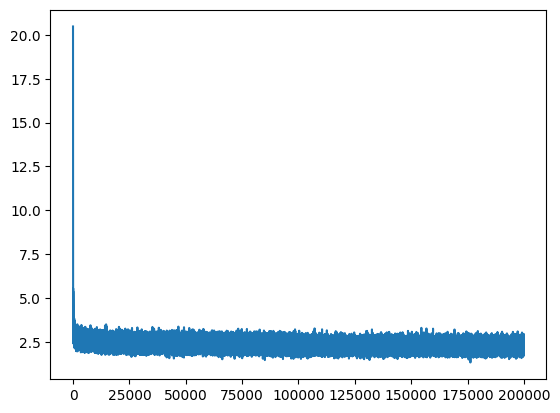

In [47]:
plt.plot(stepi, lossi)

Visualizing the character embeddings, we can see the model can cluster for eg. vowels a, e, i, o, u.

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

## experiment: larger hidden layer, larger embedding size

Now we can experiment a larger hidden layer (300), and larger embedding_size (10). Below is the whole code:

In [49]:
#| code-fold: true

# hyper-parameters
block_size = 3 # number of chracters / inputs to predict the nextone
no_chars = 27 # number of possible chracters, include '.'
emb_size = 10 # no of dimensions of the embedding space.
hidden_size = 300 # size of the hidden - tanh layer
batch_size = 32 # minibatch size for training, 2, 4, 8, 16, 32, 64, etc

# build the dataset
def buid_dataset(words):

    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

# 80 - 10 - 10 splits
Xtr, Ytr = buid_dataset(words[:n1])
Xdev, Ydev = buid_dataset(words[n1:n2])
Xte, Yte = buid_dataset(words[n2:])

# Lookup table - 10 dimensional space
g = torch.Generator().manual_seed(2147483647) # for reproductivity
C = torch.randn((no_chars, emb_size), generator=g)

# Layer 1 - tanh - 300 neurons
W1 = torch.randn((block_size * emb_size, hidden_size), generator=g)
b1 = torch.randn(hidden_size, generator=g)

# Layer 2 - softmax
W2 = torch.randn((hidden_size, no_chars), generator=g)
b2 = torch.randn(no_chars, generator=g)

# All params
parameters = [C, W1, b1, W2, b2]
print("No of params: ", sum(p.nelement() for p in parameters))

# Pre-training
for p in parameters:
    p.requires_grad = True

# Stats holders
lossi = []
stepi = []

# Training on Xtr, Ytr
for i in range(200_000):
    # minibatch construct                                           
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))                      
    # forward pass:
    emb = C[Xtr[ix]]                                                
    h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix]) 
    # backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.1 if i <= 100_000 else 0.01 
    for p in parameters:
        p.data += - lr * p.grad

    # track stats
    lossi.append(loss.item())
    stepi.append(i)

print("Loss on minibatch: ", loss.item())

torch.Size([182580, 3]) torch.Size([182580])
torch.Size([22767, 3]) torch.Size([22767])
torch.Size([22799, 3]) torch.Size([22799])
No of params:  17697
Loss on minibatch:  2.3133604526519775


In [50]:
emb = C[Xtr]                                 
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr)   
print("Loss on whole training set: ", loss.item())

emb = C[Xdev]                                
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)   
print("Loss on dev/validation set: ", loss.item())

emb = C[Xte]                                
h = torch.tanh(emb.view(-1, block_size * emb_size) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Yte)   
print("Loss on test set: ", loss.item())

Loss on whole training set:  2.107422351837158
Loss on dev/validation set:  2.167262315750122
Loss on test set:  2.1728055477142334


## summary of our final code, conclusion

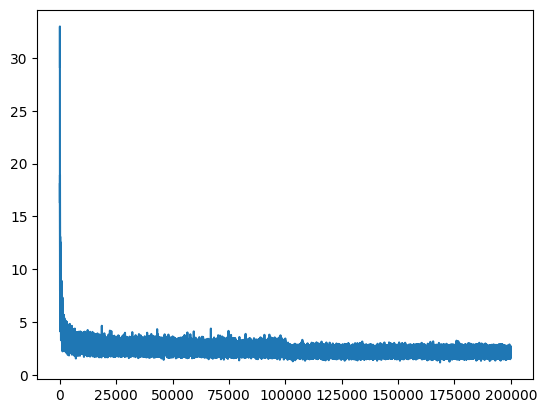

In [51]:
plt.plot(stepi, lossi)

In [ ]:
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(),C[i,1].item(), itos[i], ha="center", va="center", color="white")
plt.grid('minor')

We can see the loss on validation set and test set are quite similar as we are not try different scenarios to calibrate/tune hyperparamters much. So they both have the same suprise to the model training by `Xtr`.

We still have rooms for improvement!

## sampling from the model

But our networks now can generate more name-like name!

In [52]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
      emb = C[torch.tensor([context])] # (1,block_size,d)
      h = torch.tanh(emb.view(1, -1) @ W1 + b1)
      logits = h @ W2 + b2
      probs = F.softmax(logits, dim=1)
      ix = torch.multinomial(probs, num_samples=1, generator=g).item()
      context = context[1:] + [ix]
      out.append(ix)
      if ix == 0:
        break
    
    print(''.join(itos[i] for i in out))

mon.
ammy.
zhiee.
mel.
ryla.
rethan.
brerlee.
adeendielin.
shi.
jen.
eden.
esmanaraelynn.
hokelin.
shur.
rishiriel.
jenie.
jeniquetton.
kubakynder.
yaruemeli.
kay.


## google collab (new!!) notebook advertisement

Colab link: <https://colab.research.google.com/drive/1YIfmkftLrz6MPTOO9Vwqrop2Q5llHIGK?usp=sharing>

Thanks Andrej!

# resources

1.  [**A Neural Probabilistic Language Model**, Bengio et al. (2003)](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
2.  [Video lecturer](https://www.youtube.com/watch?v=TCH_1BHY58I)
3.  [Notebook](https://github.com/karpathy/nn-zero-to-hero/blob/master/lectures/makemore/makemore_part2_mlp.ipynb)
4.  [`makemore` on Github](https://github.com/karpathy/makemore)
5.  [`torch.Tensor()` documentation](https://pytorch.org/docs/main/tensors.html)